In [1]:
'''Trains a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for more details).

# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU

15/04/2020
Tensorflow 2 keras version
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random

import matplotlib.pyplot as plt
import cv2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

from sklearn.manifold import TSNE
from time import time
from matplotlib import offsetbox


num_classes = 10

print("tf2=",tf.__version__)

tf2= 2.1.0


In [2]:
def rotate(img, angle):
    #img = cv2.imread(img)
    (height, width) = img.shape[:2]
    (cent_x, cent_y) = (width // 2, height // 2)
    mat = cv2.getRotationMatrix2D((cent_x, cent_y), -angle, 1.0)
    return cv2.warpAffine(img, mat,(height, width))

In [93]:
# ----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, x_images, tr_dy, title=None,threshold=7e-2,sh=28,sw=28,thumbnails=True):
    #Resize Images
    images = np.zeros((x_images.shape[0], sh, sw))
    for i in range(x_images.shape[0]):
        images[i] = cv2.resize(x_images[i], (sh,sw), interpolation = cv2.INTER_AREA)
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    #X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=[9.0, 9.0])
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.scatter(X[:, 0], X[:, 1], c=tr_dy,cmap=plt.get_cmap("gist_rainbow"), label=tr_dy[0])

    if hasattr(offsetbox, 'AnnotationBbox') and thumbnails:
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < threshold:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.colorbar()
    #plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
def plot_tSNE_2D(X, tr_dx, tr_dy, title=None,threshold=7e-2,sh=28,sw=28,thumbnails=True):
    # ----------------------------------------------------------------------
    # t-SNE embedding of the digits dataset
    tsne = tsne = TSNE(n_components=2, random_state=1, n_iter=1000)
    t0 = time()
    X_tsne = tsne.fit_transform(X)
    plot_embedding(X_tsne, tr_dx, tr_dy,
               "t-SNE Plot of the Embeddings (time %.2fs)" %
               (time() - t0),threshold=7e-2,sh=28,sw=28,thumbnails=True)


In [3]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss_intra_hard(y,d):
    '''    Double contrastive loss from me 2019    '''
    # splitting data
    #labels n for same class and r for samem orientation/rotation
    # 11 distance for same class same rotation/orientation -> squeeze
    # 10 distance for same class different orientation -> squeeze up to a margin
    # 00 diatance for different class -> stretch up to a margin
    y_n,y_r           = tf.split(y,2, axis=-1)
    d_pred,d_pred_r   = tf.split(d,2, axis=-1)

    # margins for relative is little since it is in the ball of normal margin
    margin_n = 1.0
    margin_r = 0.25
    
    # same importance const
    cs=margin_n/margin_r
    
    square_pred = K.square(d_pred)
    
    margin_square_00  = K.square(K.maximum(margin_n - d_pred, 0))# -> stretch up to a margin margin_n
    margin_square_10n = K.square(K.maximum(d_pred   - margin_n, 0)) # -> squeeze up to a margin
    margin_square_10r = K.square(K.maximum(margin_r - d_pred,0))  # -> stretch up to margin margin_r
    
    # relative loss from embedding vector differences
    loss_11=square_pred                   #-> squeeze
    loss_10= margin_square_10n+margin_square_10r + d_pred_r # -> squeeze up to a margin_n but stretch up to margin_r and squeeze intra difference
    loss_1 = y_r * loss_11 + (1-y_r) * loss_10
    loss_0 =margin_square_00               # -> max up to a margin
    # main loss from embedding vectors
    loss= y_n * loss_1 + (1 - y_n) *  loss_0
    # merging losses
    loss=K.mean(loss)
    return loss


In [4]:
def create_pairs_intra(x,digit_indices,N=2,classes=[0,3,4,8,9]):
    #subclases=[0,1]
    label=range(len(classes))
    sublabel=[i+0.5 for i in label]
    dx=[]
    dy=[]
    d_n={}
    d_r={}
    for n in classes:
        d_n[n]=[]
        d_r[n]=[]
    for ni,n in enumerate(classes):
        for i in range(N):
            d_ni=x[digit_indices[n][i]]
            d_ri=rotate(d_ni,30)
            d_n[n].append(d_ni)
            d_r[n].append(d_ri)
            dx.append(d_ni)
            dy.append(label[ni])
            dx.append(d_ri)
            dy.append(sublabel[ni])
    pairs=[]
    labels=[]
    for na in range(len(classes)):
        a=classes[na]
        for nb in range(na+1,len(classes)):
            b=classes[nb]
            for i in range(N):
                dani=d_n[a][i]
                dari=d_r[a][i]
                dbni=d_n[b][i]
                dbri=d_r[b][i]
                for j in range(i+1,N):
                    danj=d_n[a][j]
                    darj=d_r[a][j]
                    dbnj=d_n[b][j]
                    dbrj=d_r[b][j]
                    pairs +=[[dani,danj,dbni,dbnj]]
                    labels+=[[1,1]]
                    pairs +=[[dari,darj,dbri,dbrj]]
                    labels+=[[1,1]]
                    pairs +=[[dbni,dbnj,dani,danj]]
                    labels+=[[1,1]]
                    pairs +=[[dbri,dbrj,dari,darj]]
                    labels+=[[1,1]]
                    pairs +=[[dani,darj,dbni,dbrj]]
                    labels+=[[1,0]]
                    pairs +=[[dbni,dbrj,dani,darj]]
                    labels+=[[1,0]]
                pairs +=[[dani,dari,dbni,dbri]]
                labels+=[[1,0]]
                pairs +=[[dbni,dbri,dani,dari]]
                labels+=[[1,0]]
                for j in range(2):
                    danj=d_n[a][j]
                    darj=d_r[a][j]
                    dbnj=d_n[b][j]
                    dbrj=d_r[b][j]
                    pairs +=[[dani,dbnj,dbnj,dani]]
                    labels+=[[0,0]]
                    pairs +=[[dani,dbrj,dbrj,dani]]
                    labels+=[[0,0]]
                    pairs +=[[dari,dbnj,dbnj,dari]]
                    labels+=[[0,0]]
                    pairs +=[[dari,dbrj,dbrj,dari]]
                    labels+=[[0,0]]         
    return np.array(dx).astype("float32"),np.array(dy).astype("float32"),np.expand_dims(np.array(pairs).astype("float32"),axis=-1), np.array(labels).astype("float32")

In [5]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    #for 2D view
    x = Dense(  2)(x)
    return Model(input, x)


In [6]:
# Accuracy for the moment is just put in the same class
def compute_accuracy(y, d_pred_e):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    y_n,y_true        = tf.split(y,2, axis=-1)
    #d_pred_e,d_pred_r = tf.split(d,2, axis=-1)

    pred = d_pred_e.ravel() < 0.25
    return np.mean(pred == y_true)


def accuracy(y, d_pred_e):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    y_n,y_true        = tf.split(y,2, axis=-1)
    #d_pred_e,d_pred_r = tf.split(d,2, axis=-1)
    return K.mean(K.equal(y_true, K.cast(d_pred_e < 0.25, y_true.dtype)))

In [7]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype("float32")
y_test  = y_test.astype("float32")
x_train /= 255
x_test /= 255
input_shape = (x_train.shape[1],x_train.shape[1],1)
#input_shape = x_train.shape[1:]

print(input_shape)

(28, 28, 1)


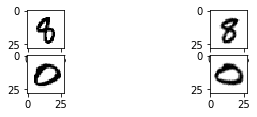

In [8]:
for i in range(2):
    plt.subplot(5,2,i*2+1)
    idx=random.randrange(0,x_train.shape[0])
    plt.imshow(x_train[idx], cmap="gray_r")
    #plt.show()
    imgr=rotate(x_train[idx],30)
    plt.subplot(5,2,i*2+2)
    plt.imshow(imgr,cmap="gray_r")
plt.show()

In [94]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_dx,tr_dy,tr_pairs, tr_y = create_pairs_intra(x_train, digit_indices,10)

digit_indices = [np.where(y_test  == i)[0] for i in range(num_classes)]
te_dx,tr_dy,te_pairs, te_y = create_pairs_intra(x_test, digit_indices,10)

print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape,tr_y.dtype)
print("te_pairs=",te_pairs.shape,"te_y=",te_y.shape,te_y.dtype)

tr_pairs= (3700, 4, 28, 28, 1) tr_y= (3700, 2) float32
te_pairs= (3700, 4, 28, 28, 1) te_y= (3700, 2) float32


In [95]:
# network definition
def buildModel():
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    input_c = Input(shape=input_shape)
    input_d = Input(shape=input_shape)

    # because we re-use the same instance `base_network`,
    # the weights of the network
    # will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    processed_c = base_network(input_c)
    processed_d = base_network(input_d)

    distanceab = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([processed_a, processed_b])

    difdc=processed_d - processed_c
    difba=processed_b - processed_a
    distancedd = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([difba, difdc])

    concat = concatenate([distanceab,distancedd])

    model = Model([input_a, input_b, input_c, input_d], concat)
    return model

In [96]:
base_network = create_base_network(input_shape)
model=buildModel()
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 28, 28, 1)]  0                                            
___________________________________________________________________________________________

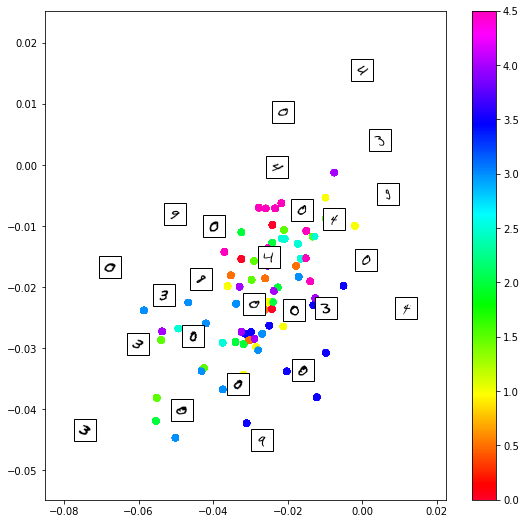

In [99]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plot_embedding(x_test_encoded, tr_dx, tr_dy, title=None,threshold=7e-5,sh=14,sw=14)

In [100]:
# train
epochs = 20
batch_size=1000
rms = RMSprop()
model.compile(loss=contrastive_loss_intra_hard, optimizer=rms, metrics=[accuracy])

In [105]:
model.fit([tr_pairs[:, 0], tr_pairs[:, 1],tr_pairs[:, 2], tr_pairs[:, 3]], tr_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1],te_pairs[:, 2], te_pairs[:, 3]], te_y))

Train on 3700 samples, validate on 3700 samples
Epoch 1/20
3700/3700 [==============================] - 2s 500us/sample - loss: 0.0704 - accuracy: 0.7205 - val_loss: 0.1857 - val_accuracy: 0.6029
Epoch 2/20
3700/3700 [==============================] - 2s 492us/sample - loss: 0.0609 - accuracy: 0.7217 - val_loss: 0.1975 - val_accuracy: 0.6067
Epoch 3/20
3700/3700 [==============================] - 2s 492us/sample - loss: 0.0558 - accuracy: 0.7184 - val_loss: 0.1857 - val_accuracy: 0.6067
Epoch 4/20
3700/3700 [==============================] - 2s 493us/sample - loss: 0.0528 - accuracy: 0.7252 - val_loss: 0.2136 - val_accuracy: 0.5943
Epoch 5/20
3700/3700 [==============================] - 2s 501us/sample - loss: 0.0477 - accuracy: 0.7221 - val_loss: 0.2239 - val_accuracy: 0.5940
Epoch 6/20
3700/3700 [==============================] - 2s 506us/sample - loss: 0.0459 - accuracy: 0.7291 - val_loss: 0.2355 - val_accuracy: 0.6018
Epoch 7/20
3700/3700 [==============================] - 2s 509us

In [53]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 4 array(s), for inputs ['input_12', 'input_13', 'input_14', 'input_15'] but instead got the following list of 2 arrays: [array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
    ...

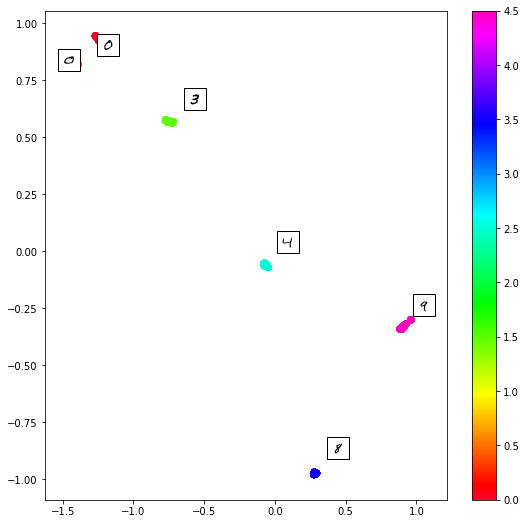

In [107]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plot_embedding(x_test_encoded, tr_dx, tr_dy, title=None,threshold=7e-2,sh=14,sw=14,thumbnails=True)

In [78]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_dx,tr_dy,tr_pairs, tr_y = create_pairs_intra(x_train, digit_indices,10,[4,9])
print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape,tr_y.dtype)

tr_pairs= (370, 4, 28, 28, 1) tr_y= (370, 2) float32


In [79]:
# network definition
base_network = create_base_network(input_shape)
model = buildModel()

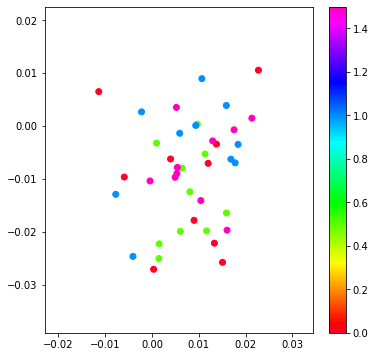

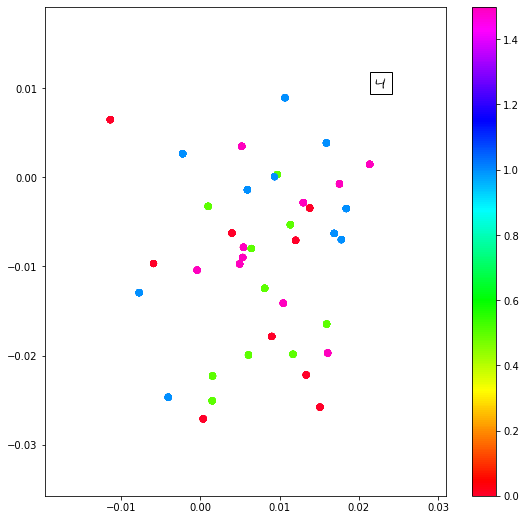

In [80]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=tr_dy,cmap=plt.get_cmap("gist_rainbow"))
plt.colorbar()
plt.show()
plot_embedding(x_test_encoded, tr_dx, tr_dy, title=None,threshold=7e-3,sh=14,sw=14)

In [81]:
rms = RMSprop()
model.compile(loss=contrastive_loss_intra_hard, optimizer=rms, metrics=[accuracy])

In [89]:
# train
epochs = 10
batch_size=1000
model.fit([tr_pairs[:, 0], tr_pairs[:, 1],tr_pairs[:, 2], tr_pairs[:, 3]], tr_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1],te_pairs[:, 2], te_pairs[:, 3]], te_y))

Train on 370 samples, validate on 3700 samples
Epoch 1/10
370/370 [==============================] - 0s 1ms/sample - loss: 0.0752 - accuracy: 0.6635 - val_loss: 0.2151 - val_accuracy: 0.5427
Epoch 2/10
370/370 [==============================] - 0s 1ms/sample - loss: 0.0891 - accuracy: 0.7000 - val_loss: 0.2518 - val_accuracy: 0.5568
Epoch 3/10
370/370 [==============================] - 1s 1ms/sample - loss: 0.0688 - accuracy: 0.6500 - val_loss: 0.2173 - val_accuracy: 0.5412
Epoch 4/10
370/370 [==============================] - 1s 1ms/sample - loss: 0.0672 - accuracy: 0.6932 - val_loss: 0.2540 - val_accuracy: 0.5558
Epoch 5/10
370/370 [==============================] - 0s 1ms/sample - loss: 0.0645 - accuracy: 0.7041 - val_loss: 0.2193 - val_accuracy: 0.5388
Epoch 6/10
370/370 [==============================] - 0s 1ms/sample - loss: 0.0712 - accuracy: 0.7068 - val_loss: 0.2348 - val_accuracy: 0.5539
Epoch 7/10
370/370 [==============================] - 1s 1ms/sample - loss: 0.0782 - accu

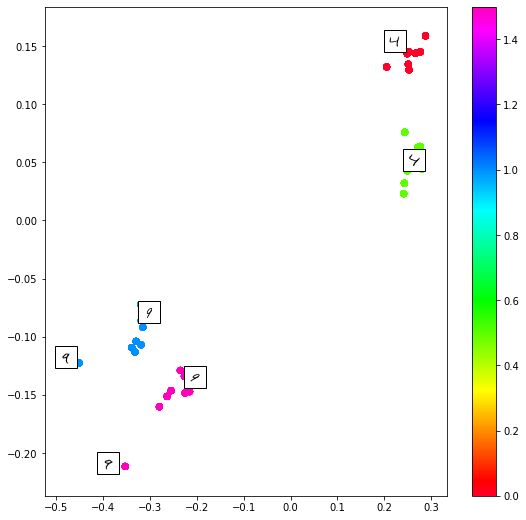

In [90]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plot_embedding(x_test_encoded, tr_dx, tr_dy, title=None,threshold=7e-3,sh=14,sw=14)

Computing t-SNE embedding


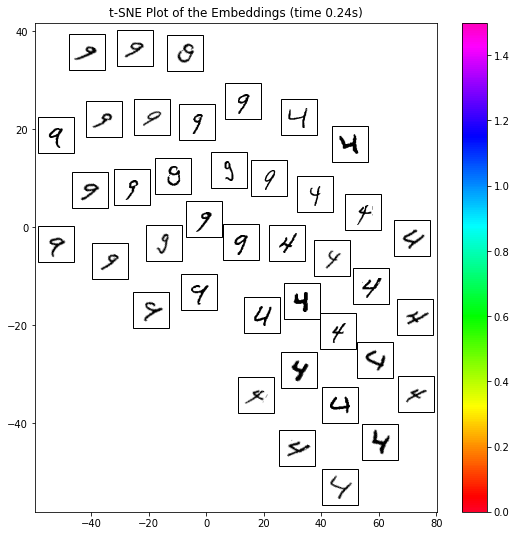

In [86]:
 #Test Model
batch_size=128
encoder=base_network
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)

# Plot results with T-SNE
X = x_test_encoded
y = tr_dy


n_samples = x_test_encoded.shape[0]
n_feature = 128
n_neighbors = 0


# ----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = tsne = TSNE(n_components=2, random_state=1, n_iter=1000)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, tr_dx, tr_dy,
               "t-SNE Plot of the Embeddings (time %.2fs)" %
               (time() - t0))

